<a href="https://colab.research.google.com/github/GabeMaldonado/JupyterNotebooks/blob/master/Darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install u8darts


     |████████████████████████████████| 92kB 2.4MB/s 
     |████████████████████████████████| 788kB 8.9MB/s 
     |████████████████████████████████| 9.5MB 10.0MB/s 
     |████████████████████████████████| 1.5MB 38.5MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 358kB 40.5MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.16.1 which is incompatible.
ERROR: pmdarima 1.7.1 has requirement Cython<0.29.18,>=0.29, but you'll have cython 0.29.21 which is incompatible.
ERROR: pmdarima 1.7.1 has requirement setuptools<50.0.0, but you'll have setuptools 50.3.0 which is incompatible.
ERROR: pmdarima 1.7.1 has requirement statsmodels<0.12,>=0.11, but you'll have statsmodels 0.12.0 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling pr

In [2]:
!pip install torch

In [1]:
!pip install fbprophet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.preprocessing import ScalerWrapper
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [2]:

# Number of previous time stamps taken into account.
SEQ_LENGTH = 12
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

In [3]:
import pandas as pd
from darts import TimeSeries

path = "/content/airline_passengers.csv"
#df = pd.read_csv('/content/Trail_LIC007.csv', parse_dates=True, index_col='TimeStamp')
df = pd.read_csv(path)
df = df.dropna()


In [4]:
df.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.tail()

,Month,Thousands of Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


In [8]:
df1 = df[['date', 'CO2']]
df1.head()

,date,CO2
0,2015-02-04 17:51:00,721.25
1,2015-02-04 17:51:59,714.00
2,2015-02-04 17:53:00,713.50
3,2015-02-04 17:54:00,708.25
4,2015-02-04 17:55:00,704.50


In [63]:
df = df.asfreq('5T', method='ffill')
df.to_csv('resampled.csv')

In [64]:
df3 = pd.read_csv('/resampled.csv')
df3.head()

FileNotFoundError: ignored

In [44]:
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.180,27.272,426.0,721.25,0.004793,1
2015-02-04 17:56:00,23.100,27.200,419.0,701.00,0.004757,1
2015-02-04 18:01:00,23.075,27.150,419.0,690.25,0.004741,1
2015-02-04 18:06:00,23.000,27.125,418.5,680.50,0.004715,1
2015-02-04 18:11:00,22.890,27.390,0.0,689.50,0.004730,0


In [ ]:
df1 = pd.to_datetime(df1['TimeStamp'])
df1

0       2020-06-27 07:07:00
1       2020-06-27 07:12:00
2       2020-06-27 07:17:00
3       2020-06-27 07:22:00
4       2020-06-27 07:27:00
                ...        
25398   2020-09-23 11:37:00
25399   2020-09-23 11:42:00
25400   2020-09-23 11:47:00
25401   2020-09-23 11:52:00
25402   2020-09-23 11:57:00
Name: TimeStamp, Length: 25310, dtype: datetime64[ns]

In [46]:
df1 = df['CO2']
df1.head()

date
2015-02-04 17:51:00    721.25
2015-02-04 17:56:00    701.00
2015-02-04 18:01:00    690.25
2015-02-04 18:06:00    680.50
2015-02-04 18:11:00    689.50
Freq: 5T, Name: CO2, dtype: float64

In [58]:
df2 = pd.DataFrame(df1)
df2.head()

,CO2
date,
2015-02-04 17:51:00,721.25
2015-02-04 17:56:00,701.00
2015-02-04 18:01:00,690.25
2015-02-04 18:06:00,680.50
2015-02-04 18:11:00,689.50


In [7]:
series = TimeSeries.from_dataframe(df, 'Month', 'Thousands of Passengers')
#train, val = df1.loc[df1.index <= '2020-08-15'], df1.loc[df1.index > '2020-08-15']
train, val = series.split_after(pd.Timestamp('19590101'))

In [8]:

train

              0
Month          
1949-01-01  112
1949-02-01  118
1949-03-01  132
1949-04-01  129
1949-05-01  121
...         ...
1958-09-01  404
1958-10-01  359
1958-11-01  310
1958-12-01  337
1959-01-01  360

[121 rows x 1 columns]
Freq: MS

In [9]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [10]:
my_model = RNNModel(
    model='LSTM',
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Level_RNN', log_tensorboard=True
)

In [13]:
my_model.fit(train_transformed, val_transformed, verbose=True)  # 107

  1%|▏         | 5/400 [00:00<00:22, 17.41it/s]

  4%|▎         | 14/400 [00:00<00:19, 20.07it/s]

  6%|▌         | 23/400 [00:01<00:17, 21.51it/s]

  9%|▉         | 35/400 [00:01<00:16, 21.54it/s]

 11%|█         | 44/400 [00:02<00:16, 21.75it/s]

 13%|█▎        | 53/400 [00:02<00:16, 21.30it/s]

 16%|█▋        | 65/400 [00:03<00:15, 21.61it/s]

 18%|█▊        | 74/400 [00:03<00:14, 22.12it/s]

 21%|██        | 83/400 [00:03<00:14, 21.93it/s]

 24%|██▍       | 95/400 [00:04<00:13, 22.08it/s]

 26%|██▌       | 104/400 [00:04<00:13, 21.44it/s]

 28%|██▊       | 113/400 [00:05<00:13, 21.60it/s]

 31%|███▏      | 125/400 [00:05<00:12, 21.63it/s]

 34%|███▎      | 134/400 [00:06<00:12, 21.61it/s]

 36%|███▌      | 143/400 [00:06<00:11, 21.42it/s]

 39%|███▉      | 155/400 [00:07<00:11, 21.69it/s]

 41%|████      | 164/400 [00:07<00:11, 21.14it/s]

 43%|████▎     | 173/400 [00:08<00:10, 21.46it/s]

 46%|████▋     | 185/400 [00:08<00:09, 21.80it/s]

 48%|████▊     | 194/400 [00:08<00:09, 21.95it/s]

 51%|█████     | 203/400 [00:09<00:09, 21.55it/s]

 54%|█████▍    | 215/400 [00:09<00:08, 21.39it/s]

 56%|█████▌    | 224/400 [00:10<00:08, 21.53it/s]

 58%|█████▊    | 233/400 [00:10<00:07, 21.76it/s]

 61%|██████▏   | 245/400 [00:11<00:07, 21.94it/s]

 64%|██████▎   | 254/400 [00:11<00:06, 21.84it/s]

 66%|██████▌   | 263/400 [00:12<00:06, 21.82it/s]

 69%|██████▉   | 275/400 [00:12<00:05, 21.33it/s]

 71%|███████   | 284/400 [00:13<00:05, 21.64it/s]

 73%|███████▎  | 293/400 [00:13<00:04, 21.68it/s]

 76%|███████▋  | 305/400 [00:14<00:04, 21.73it/s]

 78%|███████▊  | 314/400 [00:14<00:03, 21.85it/s]

 81%|████████  | 323/400 [00:14<00:03, 21.90it/s]

 84%|████████▍ | 335/400 [00:15<00:03, 21.52it/s]

 86%|████████▌ | 344/400 [00:15<00:02, 21.72it/s]

 88%|████████▊ | 353/400 [00:16<00:02, 21.86it/s]

 91%|█████████▏| 365/400 [00:16<00:01, 21.46it/s]

 94%|█████████▎| 374/400 [00:17<00:01, 21.48it/s]

 96%|█████████▌| 383/400 [00:17<00:00, 21.62it/s]

 99%|█████████▉| 395/400 [00:18<00:00, 21.83it/s]

100%|██████████| 400/400 [00:18<00:00, 21.62it/s]


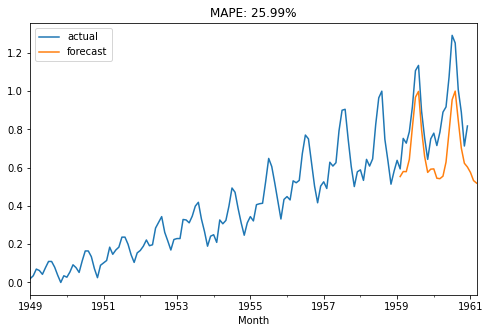

In [14]:

def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model)

loading model_best_250.pth.tar


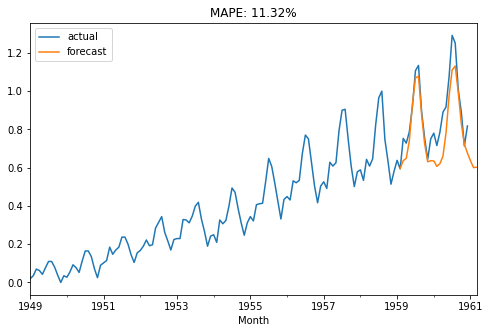

In [15]:
best_model = RNNModel.load_from_checkpoint(model_name='Level_RNN', best=True)
eval_model(best_model)

In [16]:
from darts.backtesting import backtest_forecasting

my_model = RNNModel(
    model='RNN',
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    batch_size=32,
    n_epochs=200,
    optimizer_kwargs={'lr': 1e-3},
    model_name='Air_RNN'
)

# Perform the actual backtest
backtest_series = backtest_forecasting(series_transformed, my_model, pd.Timestamp('19590101'), 
                                       fcast_horizon_n=6, verbose=True)

100%|██████████| 19/19 [00:40<00:00,  2.14s/it]


MAPE: 8.96%


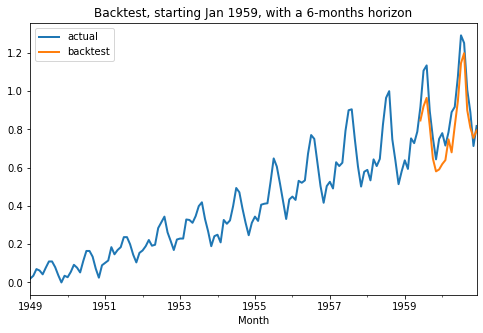

In [17]:

plt.figure(figsize=(8,5))
series_transformed.plot(label='actual', lw=2)
backtest_series.plot(label='backtest', lw=2)
plt.legend()
plt.title('Backtest, starting Jan 1959, with a 6-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                 transformer.inverse_transform(backtest_series))))

In [18]:

my_model_gru = RNNModel(
    model='GRU',
    output_length=OUTPUT_LEN*4,
    input_length=SEQ_LENGTH,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    batch_size=64,
    n_epochs=1500,
    model_name='Air_GRU_out12',
    log_tensorboard=True
)

In [19]:
my_model_gru.fit(train_transformed, val_series=val_transformed, verbose=True)

  1%|          | 8/1500 [00:00<00:39, 37.68it/s]

  1%|          | 16/1500 [00:00<00:39, 37.32it/s]

  2%|▏         | 28/1500 [00:00<00:39, 37.36it/s]

  2%|▏         | 36/1500 [00:00<00:40, 36.58it/s]

  3%|▎         | 48/1500 [00:01<00:38, 37.49it/s]

  4%|▎         | 56/1500 [00:01<00:38, 37.58it/s]

  5%|▍         | 68/1500 [00:01<00:38, 37.44it/s]

  5%|▌         | 76/1500 [00:02<00:38, 37.39it/s]

  6%|▌         | 88/1500 [00:02<00:38, 37.02it/s]

  6%|▋         | 96/1500 [00:02<00:38, 36.21it/s]

  7%|▋         | 108/1500 [00:02<00:38, 36.13it/s]

  8%|▊         | 116/1500 [00:03<00:38, 36.40it/s]

  9%|▊         | 128/1500 [00:03<00:37, 36.67it/s]

  9%|▉         | 136/1500 [00:03<00:37, 36.72it/s]

 10%|▉         | 148/1500 [00:04<00:36, 37.52it/s]

 10%|█         | 156/1500 [00:04<00:36, 37.02it/s]

 11%|█         | 168/1500 [00:04<00:36, 36.32it/s]

 12%|█▏        | 176/1500 [00:04<00:36, 36.09it/s]

 13%|█▎        | 188/1500 [00:05<00:36, 36.23it/s]

 13%|█▎        | 196/1500 [00:05<00:35, 36.49it/s]

 14%|█▍        | 208/1500 [00:05<00:34, 37.31it/s]

 14%|█▍        | 216/1500 [00:05<00:34, 36.96it/s]

 15%|█▌        | 228/1500 [00:06<00:34, 37.04it/s]

 16%|█▌        | 236/1500 [00:06<00:34, 36.76it/s]

 17%|█▋        | 248/1500 [00:06<00:34, 36.51it/s]

 17%|█▋        | 256/1500 [00:06<00:33, 36.73it/s]

 18%|█▊        | 268/1500 [00:07<00:32, 37.41it/s]

 18%|█▊        | 276/1500 [00:07<00:33, 36.53it/s]

 19%|█▉        | 284/1500 [00:07<00:35, 34.41it/s]

 20%|█▉        | 296/1500 [00:08<00:33, 36.18it/s]

 21%|██        | 308/1500 [00:08<00:32, 37.12it/s]

 21%|██        | 316/1500 [00:08<00:32, 36.71it/s]

 22%|██▏       | 328/1500 [00:08<00:31, 37.21it/s]

 22%|██▏       | 336/1500 [00:09<00:31, 36.77it/s]

 23%|██▎       | 348/1500 [00:09<00:31, 36.04it/s]

 24%|██▎       | 356/1500 [00:09<00:31, 36.46it/s]

 25%|██▍       | 368/1500 [00:10<00:31, 36.45it/s]

 25%|██▌       | 376/1500 [00:10<00:31, 35.98it/s]

 26%|██▌       | 388/1500 [00:10<00:31, 35.75it/s]

 26%|██▋       | 396/1500 [00:10<00:31, 35.49it/s]

 27%|██▋       | 408/1500 [00:11<00:29, 36.61it/s]

 28%|██▊       | 416/1500 [00:11<00:29, 36.86it/s]

 29%|██▊       | 428/1500 [00:11<00:28, 36.99it/s]

 29%|██▉       | 436/1500 [00:11<00:29, 36.37it/s]

 30%|██▉       | 448/1500 [00:12<00:28, 37.40it/s]

 30%|███       | 456/1500 [00:12<00:28, 36.83it/s]

 31%|███       | 468/1500 [00:12<00:28, 36.84it/s]

 32%|███▏      | 476/1500 [00:13<00:28, 36.04it/s]

 33%|███▎      | 488/1500 [00:13<00:27, 36.60it/s]

 33%|███▎      | 496/1500 [00:13<00:27, 36.93it/s]

 34%|███▍      | 508/1500 [00:13<00:26, 36.90it/s]

 34%|███▍      | 516/1500 [00:14<00:26, 37.14it/s]

 35%|███▌      | 528/1500 [00:14<00:25, 37.40it/s]

 36%|███▌      | 536/1500 [00:14<00:26, 37.00it/s]

 37%|███▋      | 548/1500 [00:15<00:26, 36.45it/s]

 37%|███▋      | 556/1500 [00:15<00:25, 37.04it/s]

 38%|███▊      | 568/1500 [00:15<00:25, 36.54it/s]

 38%|███▊      | 576/1500 [00:15<00:25, 35.76it/s]

 39%|███▉      | 588/1500 [00:16<00:24, 36.63it/s]

 40%|███▉      | 596/1500 [00:16<00:24, 36.86it/s]

 40%|████      | 604/1500 [00:16<00:25, 35.66it/s]

 41%|████      | 617/1500 [00:16<00:24, 35.56it/s]

 42%|████▏     | 625/1500 [00:17<00:24, 36.10it/s]

 42%|████▏     | 637/1500 [00:17<00:23, 36.16it/s]

 43%|████▎     | 645/1500 [00:17<00:23, 36.08it/s]

 44%|████▍     | 657/1500 [00:18<00:23, 36.53it/s]

 44%|████▍     | 665/1500 [00:18<00:22, 36.33it/s]

 45%|████▌     | 677/1500 [00:18<00:22, 35.97it/s]

 46%|████▌     | 685/1500 [00:18<00:22, 35.97it/s]

 46%|████▋     | 697/1500 [00:19<00:22, 36.45it/s]

 47%|████▋     | 705/1500 [00:19<00:21, 36.82it/s]

 48%|████▊     | 717/1500 [00:19<00:21, 36.40it/s]

 48%|████▊     | 725/1500 [00:19<00:21, 35.71it/s]

 49%|████▉     | 737/1500 [00:20<00:21, 35.99it/s]

 50%|████▉     | 745/1500 [00:20<00:21, 35.85it/s]

 50%|█████     | 757/1500 [00:20<00:20, 36.58it/s]

 51%|█████     | 765/1500 [00:21<00:20, 36.69it/s]

 52%|█████▏    | 777/1500 [00:21<00:19, 37.09it/s]

 52%|█████▏    | 785/1500 [00:21<00:19, 36.62it/s]

 53%|█████▎    | 797/1500 [00:21<00:18, 37.10it/s]

 54%|█████▎    | 805/1500 [00:22<00:18, 36.77it/s]

 54%|█████▍    | 817/1500 [00:22<00:18, 37.26it/s]

 55%|█████▌    | 825/1500 [00:22<00:18, 36.27it/s]

 56%|█████▌    | 837/1500 [00:22<00:18, 36.21it/s]

 56%|█████▋    | 845/1500 [00:23<00:18, 36.36it/s]

 57%|█████▋    | 857/1500 [00:23<00:17, 36.69it/s]

 58%|█████▊    | 865/1500 [00:23<00:17, 37.00it/s]

 58%|█████▊    | 877/1500 [00:24<00:16, 37.03it/s]

 59%|█████▉    | 885/1500 [00:24<00:16, 37.43it/s]

 60%|█████▉    | 897/1500 [00:24<00:16, 37.10it/s]

 60%|██████    | 905/1500 [00:24<00:16, 36.44it/s]

 61%|██████    | 917/1500 [00:25<00:16, 35.62it/s]

 62%|██████▏   | 925/1500 [00:25<00:16, 35.82it/s]

 62%|██████▏   | 937/1500 [00:25<00:15, 36.23it/s]

 63%|██████▎   | 945/1500 [00:25<00:15, 36.77it/s]

 64%|██████▍   | 957/1500 [00:26<00:14, 36.60it/s]

 64%|██████▍   | 965/1500 [00:26<00:14, 36.56it/s]

 65%|██████▌   | 977/1500 [00:26<00:14, 36.99it/s]

 66%|██████▌   | 985/1500 [00:27<00:14, 36.12it/s]

 66%|██████▋   | 997/1500 [00:27<00:14, 35.42it/s]

 67%|██████▋   | 1005/1500 [00:27<00:13, 35.82it/s]

 68%|██████▊   | 1017/1500 [00:27<00:13, 36.49it/s]

 68%|██████▊   | 1025/1500 [00:28<00:13, 35.67it/s]

 69%|██████▉   | 1037/1500 [00:28<00:12, 35.75it/s]

 70%|██████▉   | 1045/1500 [00:28<00:12, 35.32it/s]

 70%|███████   | 1057/1500 [00:29<00:12, 36.18it/s]

 71%|███████   | 1065/1500 [00:29<00:12, 35.06it/s]

 72%|███████▏  | 1077/1500 [00:29<00:11, 35.79it/s]

 72%|███████▏  | 1085/1500 [00:29<00:11, 35.84it/s]

 73%|███████▎  | 1097/1500 [00:30<00:11, 36.09it/s]

 74%|███████▎  | 1105/1500 [00:30<00:11, 34.98it/s]

 74%|███████▍  | 1117/1500 [00:30<00:11, 33.51it/s]

 75%|███████▌  | 1125/1500 [00:31<00:11, 34.00it/s]

 76%|███████▌  | 1137/1500 [00:31<00:10, 35.64it/s]

 76%|███████▋  | 1145/1500 [00:31<00:09, 36.37it/s]

 77%|███████▋  | 1157/1500 [00:31<00:09, 36.57it/s]

 78%|███████▊  | 1165/1500 [00:32<00:09, 35.69it/s]

 78%|███████▊  | 1177/1500 [00:32<00:08, 36.56it/s]

 79%|███████▉  | 1185/1500 [00:32<00:08, 36.31it/s]

 80%|███████▉  | 1197/1500 [00:33<00:08, 36.34it/s]

 80%|████████  | 1205/1500 [00:33<00:08, 36.27it/s]

 81%|████████  | 1217/1500 [00:33<00:07, 36.66it/s]

 82%|████████▏ | 1225/1500 [00:33<00:07, 36.71it/s]

 82%|████████▏ | 1237/1500 [00:34<00:07, 36.71it/s]

 83%|████████▎ | 1245/1500 [00:34<00:07, 36.07it/s]

 84%|████████▍ | 1257/1500 [00:34<00:06, 36.16it/s]

 84%|████████▍ | 1265/1500 [00:34<00:06, 36.37it/s]

 85%|████████▌ | 1277/1500 [00:35<00:06, 35.96it/s]

 86%|████████▌ | 1285/1500 [00:35<00:05, 36.38it/s]

 86%|████████▋ | 1297/1500 [00:35<00:05, 36.80it/s]

 87%|████████▋ | 1305/1500 [00:35<00:05, 36.70it/s]

 88%|████████▊ | 1317/1500 [00:36<00:05, 36.23it/s]

 88%|████████▊ | 1325/1500 [00:36<00:04, 36.49it/s]

 89%|████████▉ | 1337/1500 [00:36<00:04, 36.70it/s]

 90%|████████▉ | 1345/1500 [00:37<00:04, 36.61it/s]

 90%|█████████ | 1357/1500 [00:37<00:03, 36.09it/s]

 91%|█████████ | 1365/1500 [00:37<00:03, 36.18it/s]

 92%|█████████▏| 1377/1500 [00:37<00:03, 37.13it/s]

 92%|█████████▏| 1385/1500 [00:38<00:03, 36.14it/s]

 93%|█████████▎| 1397/1500 [00:38<00:02, 36.22it/s]

 94%|█████████▎| 1405/1500 [00:38<00:02, 35.77it/s]

 94%|█████████▍| 1417/1500 [00:39<00:02, 34.92it/s]

 95%|█████████▌| 1425/1500 [00:39<00:02, 35.39it/s]

 96%|█████████▌| 1437/1500 [00:39<00:01, 36.62it/s]

 96%|█████████▋| 1445/1500 [00:39<00:01, 36.29it/s]

 97%|█████████▋| 1457/1500 [00:40<00:01, 36.50it/s]

 98%|█████████▊| 1465/1500 [00:40<00:00, 36.87it/s]

 98%|█████████▊| 1477/1500 [00:40<00:00, 36.55it/s]

 99%|█████████▉| 1485/1500 [00:40<00:00, 36.04it/s]

100%|█████████▉| 1497/1500 [00:41<00:00, 35.96it/s]

100%|██████████| 1500/1500 [00:41<00:00, 36.24it/s]


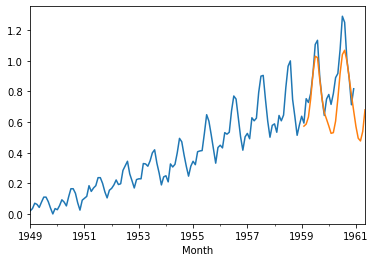

In [20]:
pred_series = my_model_gru.predict(n=28)
series_transformed.plot()
pred_series.plot()

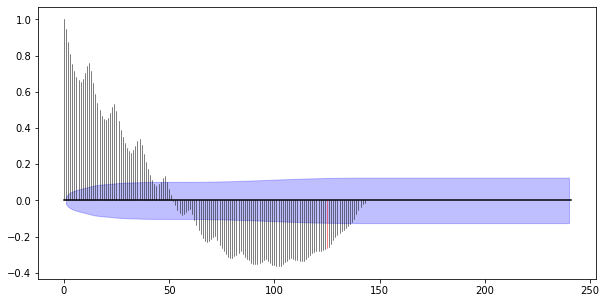

In [86]:
plot_acf(series, 125, max_lag=240) #~11 years seasonality